In [1]:
from skimage import io
import numpy as np
#%pylab inline 
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import matplotlib.image as mpimg
import cv2
from pydicom import dcmread
import math
from skimage.morphology import reconstruction, square, disk, cube
from skimage.segmentation import watershed

from scipy.ndimage import gaussian_filter
import scipy.ndimage.filters as filters
from skimage.filters import sobel, prewitt
import imageio

import math

In [ ]:
img=mpimg.imread('vhuman_t1.png')
img=img[:,:,0] 
img_in = img
img = img[100:150, 100:150]/np.max(img)
img_in = img_in[100:150, 100:150]/np.max(img_in)

In [103]:
def translation(x_t, y_t):
    
    rows, cols = np.shape(img)
    
    pad_width = np.abs(x_t*2)
    padded_img = np.pad(img, pad_width, 'constant')
    
    translated = np.zeros((rows,cols))
    padded_translated = np.pad(translated, pad_width, 'constant')
    trans_mat = np.array([[1,0,0],[0,1,0], [x_t,y_t, 1]])
    
    for i in range(0, np.shape(img)[0]):
        for j in range(0, np.shape(img)[1]):
            
            idx = np.dot([i,j,1], trans_mat)[0:2]
            padded_translated[idx[0]+pad_width, idx[1]+pad_width] = img[i, j]
            
    ### translation finished
    
            
    return padded_translated

In [70]:
a = translation(-5,-5)

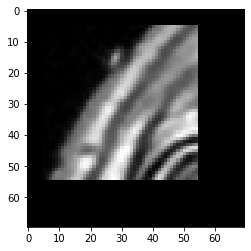

In [71]:
plt.imshow(a, cmap = "gray")

In [152]:
def rotation(theta,image):
    
    theta=math.radians(theta)
    
    a = image # original image
    print(np.shape(a))
    
    rows, cols = np.shape(a)
    pad_width = 200 #needed not to exceed limits when rotated
    padded_img = np.pad(a, pad_width, 'constant')
    
    rotated = np.zeros((rows,cols))
    padded_rotated = np.pad(rotated, pad_width, 'constant')
    
    rot_mat = np.array([[np.cos(theta),np.sin(theta),0], [-np.sin(theta), np.cos(theta),0], [0,0,1]])
    
    center_i, center_j= rows//2, cols//2
    centers = np.dot([center_i,center_j,1], rot_mat)
    
    max_i=[]
    max_j=[]
    
    for i in range(0, np.shape(a)[0]):
        for j in range(0, np.shape(a)[1]):
            
            if (i == 0 and j == 0):
                pass
            
            else:
                                
                # finding new pixels for each pixel when rotated:
                new_i = pad_width + np.dot([i,j,1], rot_mat)[0] + (center_i-centers[0]) 
                new_j = pad_width + np.dot([i,j,1], rot_mat)[1] + (center_j-centers[1]) 
                
                max_i.append(new_i)
                max_j.append(new_j)


                # corner pixels for new_i and new_j: # working
                upper_new_i = math.ceil(new_i)
                lower_new_i = math.floor(new_i)
                upper_new_j = math.ceil(new_j)
                lower_new_j = math.floor(new_j)
                

               # bilinear inteporlation: # from wikipedia >> working
                i1 = ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*padded_img[lower_new_i+0,lower_new_j+0] + ((new_j-lower_new_j)/(upper_new_j-lower_new_j))*padded_img[lower_new_i+0, upper_new_j+0]
                i2 = ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*padded_img[upper_new_i+0,lower_new_j+0] + ((new_j-lower_new_j)/(upper_new_j-lower_new_j))*padded_img[upper_new_i+0, upper_new_j+0]
                i3 = ((upper_new_i-new_i)/(upper_new_i-lower_new_i))*i1 + ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*i2

                # assign new values >>right indexing ?
                padded_rotated[i+pad_width, j+pad_width] = i3
    padded_rotated[center_i+pad_width, center_j+pad_width] = image[center_i, center_j]

    max_i=min(max_i)
    max_j=min(max_j)
    print(max_i,max_j)
    return padded_rotated[pad_width:-pad_width,pad_width:-pad_width]

In [51]:
b = rotation((10),img)

(496, 492)


C:\Anaconda3\envs\rd\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\envs\rd\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\envs\rd\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


161.2238737245745 160.84619287526502


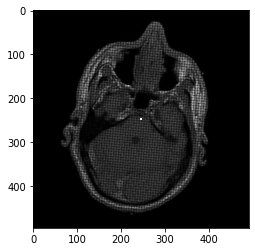

In [52]:
plt.imshow(b, cmap = "gray")

In [104]:
def mutual_information(htgrm):
    
    joint_prob = htgrm / float(np.sum(htgrm)) # joint
    x_marginal_prob = np.sum(joint_prob, axis=1) # marginal x
    py_marginal_prob = np.sum(joint_prob, axis=0) # marginal y_marginal_prob
    denominator = x_marginal_prob[:, None] * py_marginal_prob[None, :] 

    nzs = joint_prob > 0 
    return np.sum(joint_prob[nzs] * np.log(joint_prob[nzs] / denominator[nzs]))


In [161]:
b = rotation((10),img)
c = rotation((10),img)

(496, 492)


C:\Anaconda3\envs\rd\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\envs\rd\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\envs\rd\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


161.2238737245745 160.84619287526502
(496, 492)
161.2238737245745 160.84619287526502


In [155]:
(np.isnan(c)).any()
np.where(np.isnan(b))

(array([], dtype=int64), array([], dtype=int64))

In [160]:
img=mpimg.imread('vhuman_t1.png')
img=img[:,:,0] 
img_in = img

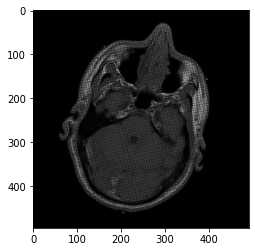

In [156]:
plt.imshow(c, cmap = "gray")

Text(0, 0.5, 'T2 signal bin')

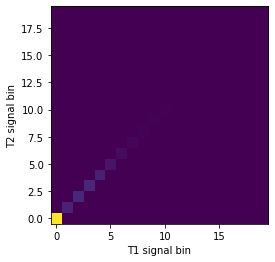

In [162]:
hist_2d, x_edges, y_edges = np.histogram2d(
    b.ravel(),
    c.ravel(),
    bins=20)
# Plot as image, arranging axes as for scatterplot
# We transpose to put the T1 bins on the horizontal axis
# and use 'lower' to put 0, 0 at the bottom of the plot
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

2.6294602034214005

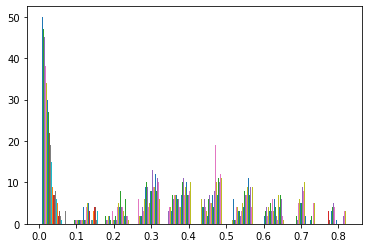

In [96]:
hist=plt.hist(img)[0]
mutual_information(joint_hist)

In [95]:
joint_hist, x_edges, y_edges = np.histogram2d(
    img.ravel(),
    img.ravel(),
    bins=20)

---
HRL